In [1]:
%matplotlib notebook
# Load data
import sys
sys.path.append('..')
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
from utils.data import fetch_data_with_label, label_to_int, divide_data, process_data_3d,process_batch_data_3d
import glob
import itertools

In [2]:
task = 'assembly'


if task == 'assembly':
        n_global_states = 4
        n_clusters = 5
        target_dir = '../../roboSim/data/assembly/*/*.pickle'
elif task == 'bin_picking':
        n_global_states = 2
        n_clusters = 2
        target_dir = '../../roboSim/data/bin_picking/*/*.pickle'
        
logfile_path = glob.glob(target_dir)
#coordinates and object kind for nut and bolt
data, label = fetch_data_with_label(logfile_path, n_global_states)
n_training = 2
n_val = 10
with_anchor = True
# # Add noise and anchor information to the data
# x, y = process_batch_data_3d(data, label, with_anchor = False, task = 'bin_picking')
x_train,y_train, x_left, y_left = divide_data(data, label, n_training)
x_val,y_val, x_test, y_test = divide_data(x_left, y_left, n_val)

x_train_processed, y_train_processed = process_batch_data_3d(x_train, y_train, with_anchor = with_anchor, task = task)
x_val_processed, y_val_processed = process_batch_data_3d(x_val, y_val, with_anchor = with_anchor, task = task)
x_test_processed, y_test_processed = process_batch_data_3d(x_test, y_test, with_anchor = with_anchor, task = task)

x_train, y_train = torch.from_numpy(x_train_processed).float(), torch.from_numpy(y_train_processed.astype(int)).view(-1, 1).long()
x_val, y_val = torch.from_numpy(x_val_processed).float(), torch.from_numpy(y_val_processed.astype(int)).view(-1, 1).long()
x_test, y_test = torch.from_numpy(x_test_processed).float(), torch.from_numpy(y_test_processed.astype(int)).view(-1, 1).long()

input_dim = x_train.shape[1]
output_dim = n_clusters


In [3]:
from torch.utils.data import Dataset, DataLoader

class Mydata(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, ind):
        return self.x[ind], self.y[ind]
    
    def __len__(self):
        return len(self.x)

data = Mydata(torch.FloatTensor(x_train), y_train)
train_loader = DataLoader(data, batch_size = 1, shuffle = True)

In [4]:
class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [5]:
def train(dataloader, net, criterion, optimizer, USE_GPU = True):
    for i, data in enumerate(dataloader):
        x, y = data
        if USE_GPU:
            x = x.cuda()
            y = y.cuda()
            net = net.cuda()
        net.zero_grad()
        output = net(x)
        loss = criterion(output, y.flatten())
        loss.backward()
        optimizer.step()
        return loss

def validate(x_val, y_val, net, criterion, USE_GPU = True):
    val_loss = 0
    n = x_val.shape[0]
    d = x_val.shape[1]
    if USE_GPU:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
        net = net.cuda()
    with torch.no_grad():
        for i in range(n):
            x = x_val[i].view(-1, d)
            output = net(x)
            val_loss += criterion(output, y_val[i])    
        val_loss = val_loss / n
    return val_loss      

<IPython.core.display.Javascript object>


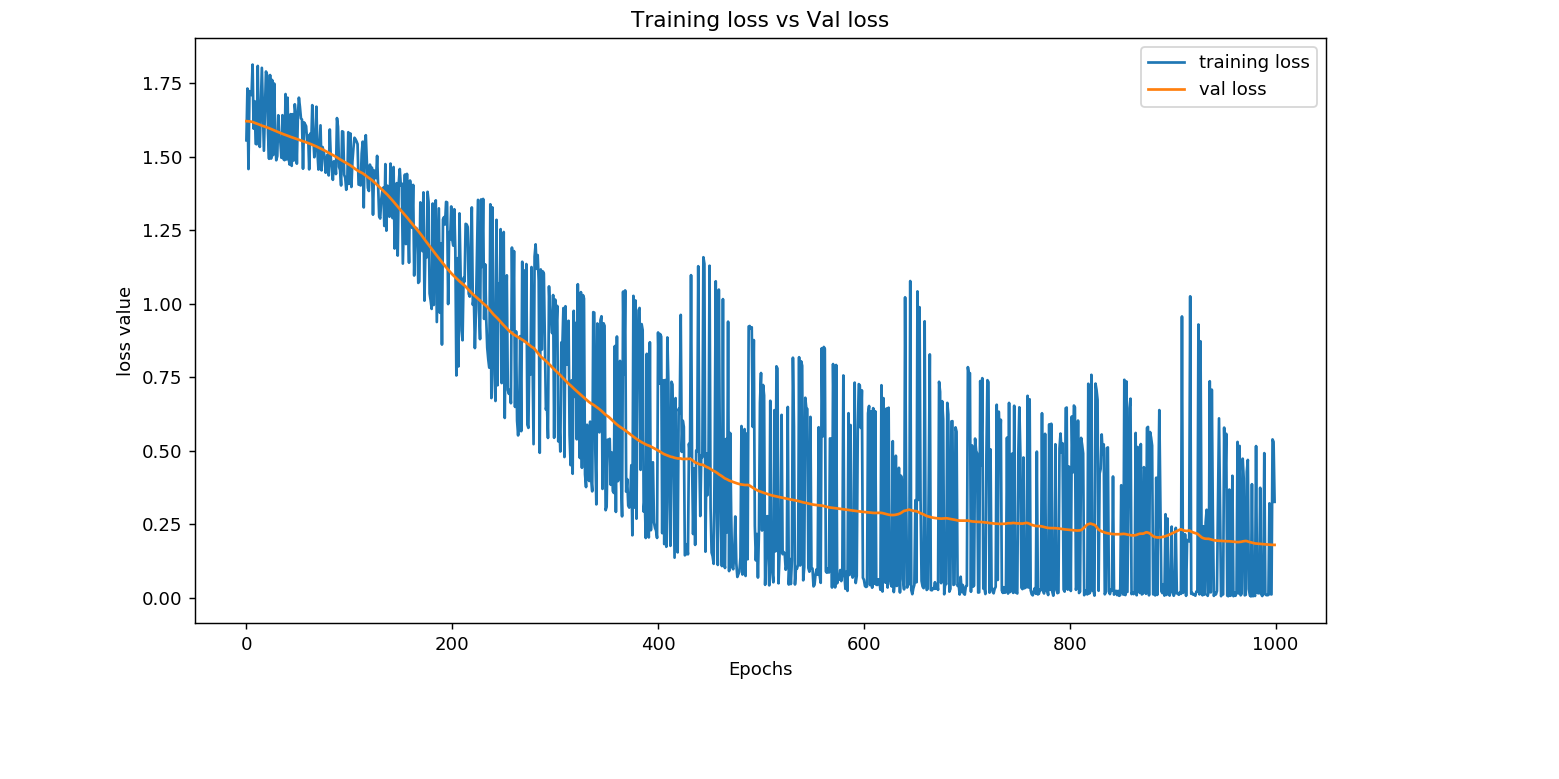

In [6]:
import torch.optim as optim
from matplotlib import pyplot as plt

epoches = 1000
mynet = MyNet(input_dim, output_dim)
optimizer = optim.Adam(mynet.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

fig = plt.figure(4, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)
val_loss_list = []
train_loss_list = []
for e in range(epoches):
#     if e > 500:
#         optimizer = optim.Adam(mynet.parameters(), lr = 0.0001)
    train_loss = train(train_loader, mynet.train(), criterion, optimizer)
    train_loss_list.append(train_loss)
    val_loss = validate(x_val, y_val, mynet.eval(), criterion)
    val_loss_list.append(val_loss) 
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_list, label='training loss')
    ax.plot(val_loss_list, label='val loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
#     print("Epoch: {} Loss: {}".format(e, train_loss))


In [10]:
def predict(x, net):
    with torch.no_grad():
        output = net(x)
        return torch.argmax(output)

def test(x_test, y_test, net, USE_GPU = True):
    n = x_test.shape[0]
    predictions = torch.zeros((n,1)).long()
    if USE_GPU:
        x_test = x_test.cuda()
        net = net.cuda()
    with torch.no_grad():
        for i in range(n):
            prediction = predict(x_test[i,:], net)
            predictions[i] = prediction
    accuracy = int(sum(predictions.detach() == y_test)) / n 
    return predictions, accuracy

In [11]:
test(x_test, y_test, mynet)

(tensor([[3],
         [3],
         [3],
         ...,
         [4],
         [4],
         [4]]), 0.9872505543237251)

In [9]:
0.9869

0.9869